# LILA-PINN evaluation script

In [1]:
import sys
sys.path.append('..')
from _utils import *
from _utils.methods import *
warnings.simplefilter(action='ignore', category=FutureWarning)

## Pre-requisites

In [2]:
# Ground truth parameters
n_ir        = 3      # Number of irregular demands
noise       = True
u_path = '../_utils/'
inp_file = u_path+'inp_files/L-town_Real.inp'

In [3]:
# Ground truth for comparison
leak_signals = pd.read_csv(
    u_path+'Data/leak_ground_truth/2019_Leakages.csv',
    sep=';',decimal=',',
    parse_dates=['Timestamp'],
    )
leak_signals.index = leak_signals['Timestamp'].values
leak_signals = leak_signals.drop(['Timestamp'],axis=1)
leak_signals /= 60

scada_flows    = extract_irregular_flows(n_ir=n_ir, inp_file=inp_file)

In [4]:
# Leakage dataset
scada_pressure = simulate_leakage_data(n_ir=n_ir, inp_file=inp_file, noise=noise, leaks=None)

In [5]:
# Analysis parameters
n_models = 100
sensor_list = ['n1','n4','n31']
labels = ['baseline regression model','model with full knowledge of industrial flows','model with PINN predictor for industrial flows']

# CPD hyperparameters
delta=1
C_thr=300
est_length='7 days'

## Leak 1

In [6]:
# leak specific parameters
name = 'l1'
leak_start = '2019-02-10 13:05:00'

train_start = '2019-01-01'
train_end   = '2019-01-14'
test_start  = '2019-01-01'
test_end    = '2019-03-31'

In [7]:
# preprocess data to torch
scaler_P = MaxAbsScaler()
P_train,P_val,P_test = preprocess2torch(
    scada_pressure,
    sensor_list,
    train_start = train_start,
    train_end   = train_end,
    test_start  = test_start,
    test_end    = test_end,
    scaler      = scaler_P,
    )
scaler_Q = MaxAbsScaler()
Q_train,Q_val,Q_test = preprocess2torch(
    scada_flows,
    train_start = train_start,
    train_end   = train_end,
    test_start  = test_start,
    test_end    = test_end,
    scaler      = scaler_Q,
    )
tank_ = scada_pressure['T1'].to_frame()
tank_ = (tank_-tank_.mean())/tank_.std()
T_train,T_val,T_test = preprocess2torch(
    tank_,
    train_start = train_start,
    train_end   = train_end,
    test_start  = test_start,
    test_end    = test_end,
    )

In [9]:
# loading pre-trained LILA-PINN models
with open(u_path+'list_model_{}_s{}.pkl'.format(name,3), 'rb') as f:
    list_model_QNET = pickle.load(f)

# training regression models for comparison
model_BL = calibrate_LILA(P_train, sensor_list=sensor_list, hyperparams=False, Q_train=T_train)
model_FK = calibrate_LILA(P_train, sensor_list=sensor_list, hyperparams=False, Q_train=torch.cat((Q_train,T_train),axis=1))

### Figure 3

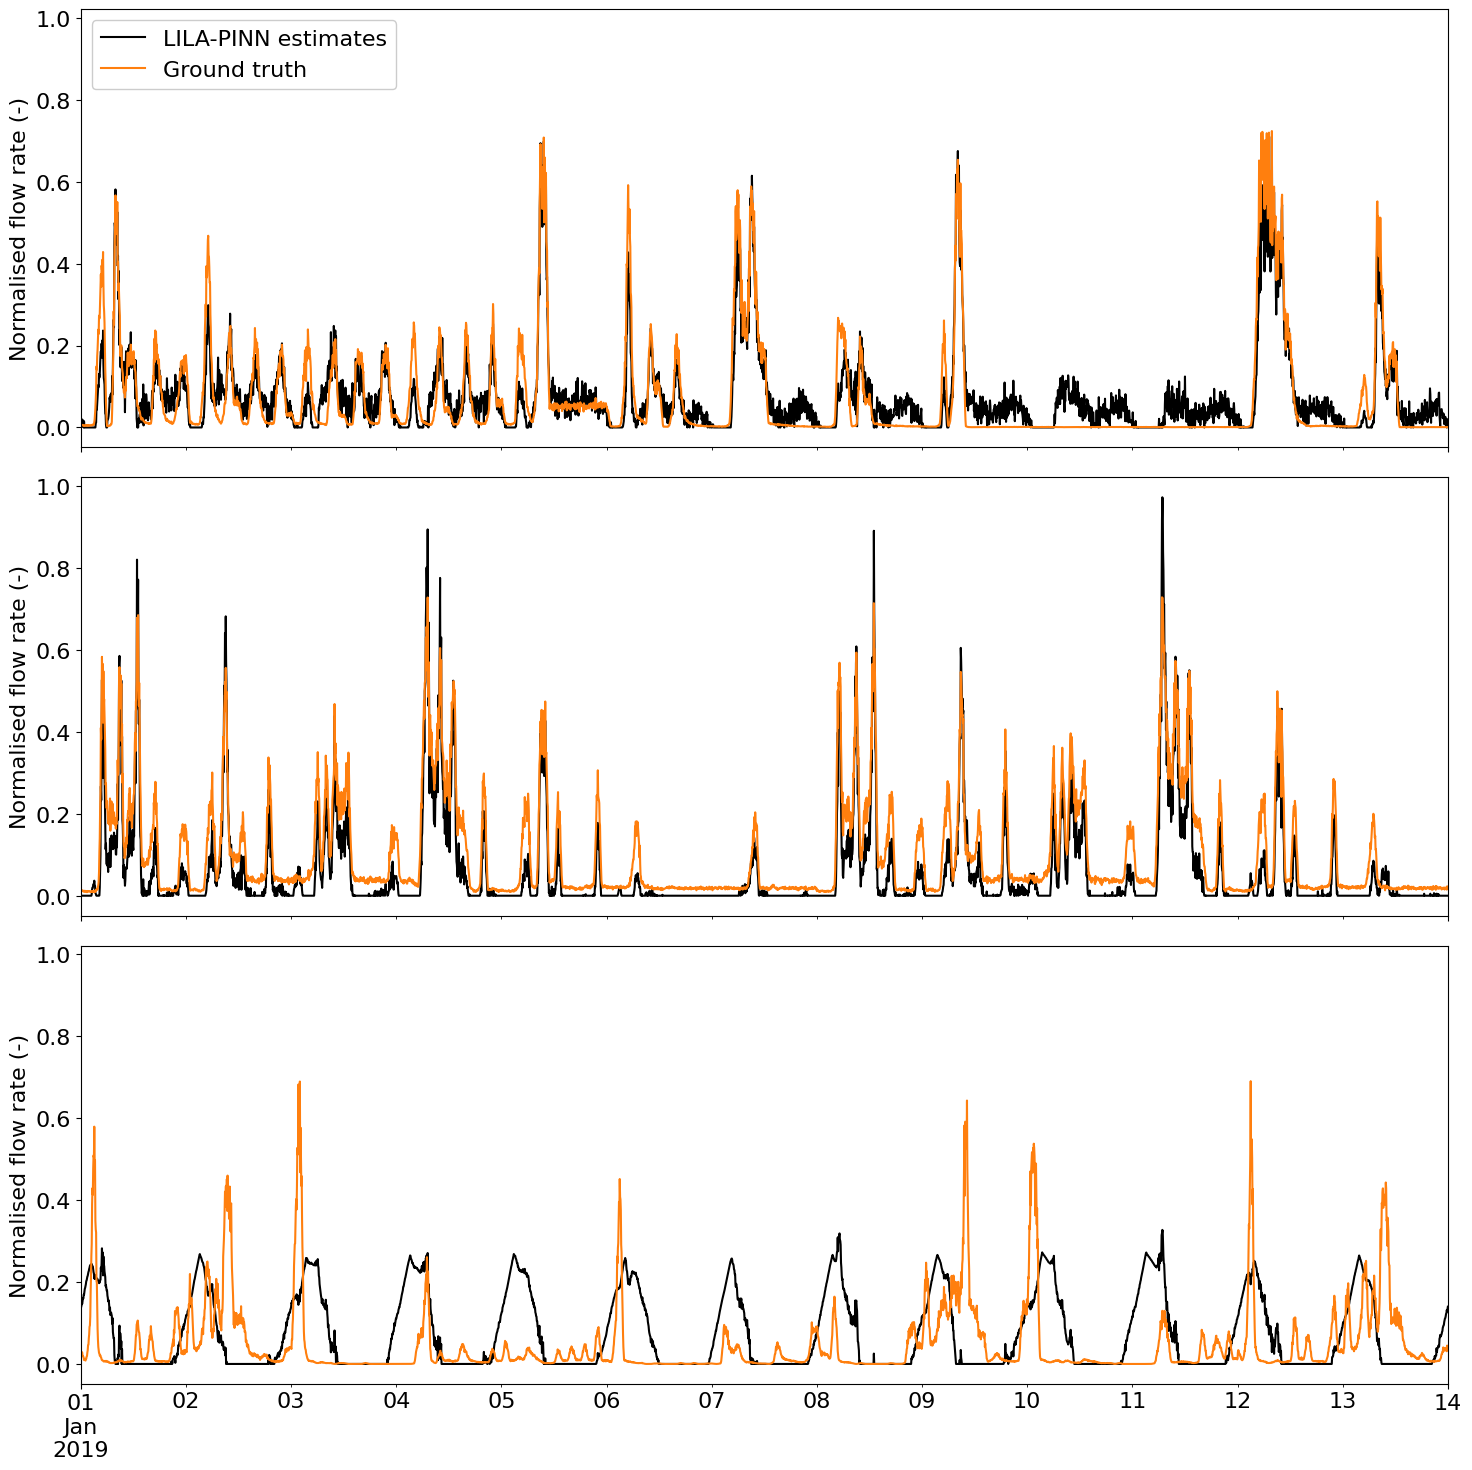

In [10]:
# displaying comparison between estimated irregular demands and ground truth
r2_scores = pd.DataFrame(columns=['p'],dtype=object)
for n,model_QNET in enumerate(list_model_QNET):
    q_true = pd.DataFrame(
        MaxAbsScaler().fit_transform(scada_flows),
        columns=scada_flows.columns,
        index=scada_flows.index,
    ).loc[test_start:test_end].values
    q_pred = model_QNET.lin_reg.qnet(P_test).detach().numpy()
    r2_max = -20
    p_max = 0
    for p in permutations(range(3)):
        r2 = 0
        for i in range(3):
            r2 += r2_score(q_true[:,i],q_pred[:,p[i]])
        if r2>r2_max:
            r2_max = r2
            p_max = p
    for i in range(3):
        r2_scores.loc[n,i] = r2_score(q_true[:,i],q_pred[:,p_max[i]])
    r2_scores.at[n,'p'] = list(p_max)
    r2_scores.loc[n,'sum'] = r2_max
    r2_scores['sum2'] = r2_scores[[0,1]].sum(axis=1)
    for i in range(3):
        r2_scores.loc[n,'rmse_{}'.format(i)] = mean_squared_error(q_true[:,i],q_pred[:,p_max[i]],squared=False)
        
        
q_true = pd.DataFrame(
    MaxAbsScaler().fit_transform(scada_flows),
    columns=['','',''],
    index=scada_flows.index,
).loc[test_start:test_end]
q_pred = pd.DataFrame(
    list_model_QNET[54].lin_reg.qnet(P_test).detach().numpy(),
    columns=['','',''],
    index=q_true.index,
)

n_add = 3
f,axs = plt.subplots(n_add,figsize=(15,5*n_add),sharex=True,sharey=True)
for d,ax in enumerate(axs):
    q_pred.iloc[:,r2_scores.loc[54,'p'][d]].loc[:'2019-01-14 00:00'].plot(
        ax=ax,
        label='LILA-PINN estimates'.format(d+1),
        color='black',
        )
    q_true.iloc[:,d].loc[:'2019-01-14 00:00'].plot(
        ax=ax,
        label='Ground truth'.format(d+1),
        color='tab:orange',
        )
    ax.set_ylabel('Normalised flow rate (-)')
    if d==0:
        ax.legend(loc=2,framealpha=1)
f.tight_layout()

In [11]:
# performing CPD

# loading results from pre-trained models
with open(u_path+'list_MRE_{}_s{}.pkl'.format(name,3), 'rb') as f:
    list_MRE_QNET = pickle.load(f)
with open(u_path+'list_c_{}_s{}.pkl'.format(name,3), 'rb') as f:
    list_c_QNET = pickle.load(f)
with open(u_path+'list_det_{}_s{}.pkl'.format(name,3), 'rb') as f:
    list_det_QNET = pickle.load(f)
    
# evaluating regression models for comparison
MRE_BL = pd.DataFrame(
    model_BL.predict_MRE(P_test,T_test).mean(axis=(1,2)).detach().numpy(),
    index=pd.date_range(start=test_start,freq='5T',periods=P_test.shape[0]),
    )
det_BL,c_BL = cusum(MRE_BL,delta=delta,C_thr=C_thr,est_length=est_length)
MRE_FK = pd.DataFrame(
    model_FK.predict_MRE(P_test,torch.cat((Q_test,T_test),axis=1)).mean(axis=(1,2)).detach().numpy(),
    index=pd.date_range(start=test_start,freq='5T',periods=P_test.shape[0]),
    )
det_FK,c_FK = cusum(MRE_FK,delta=delta,C_thr=C_thr,est_length=est_length)

### Figure 4

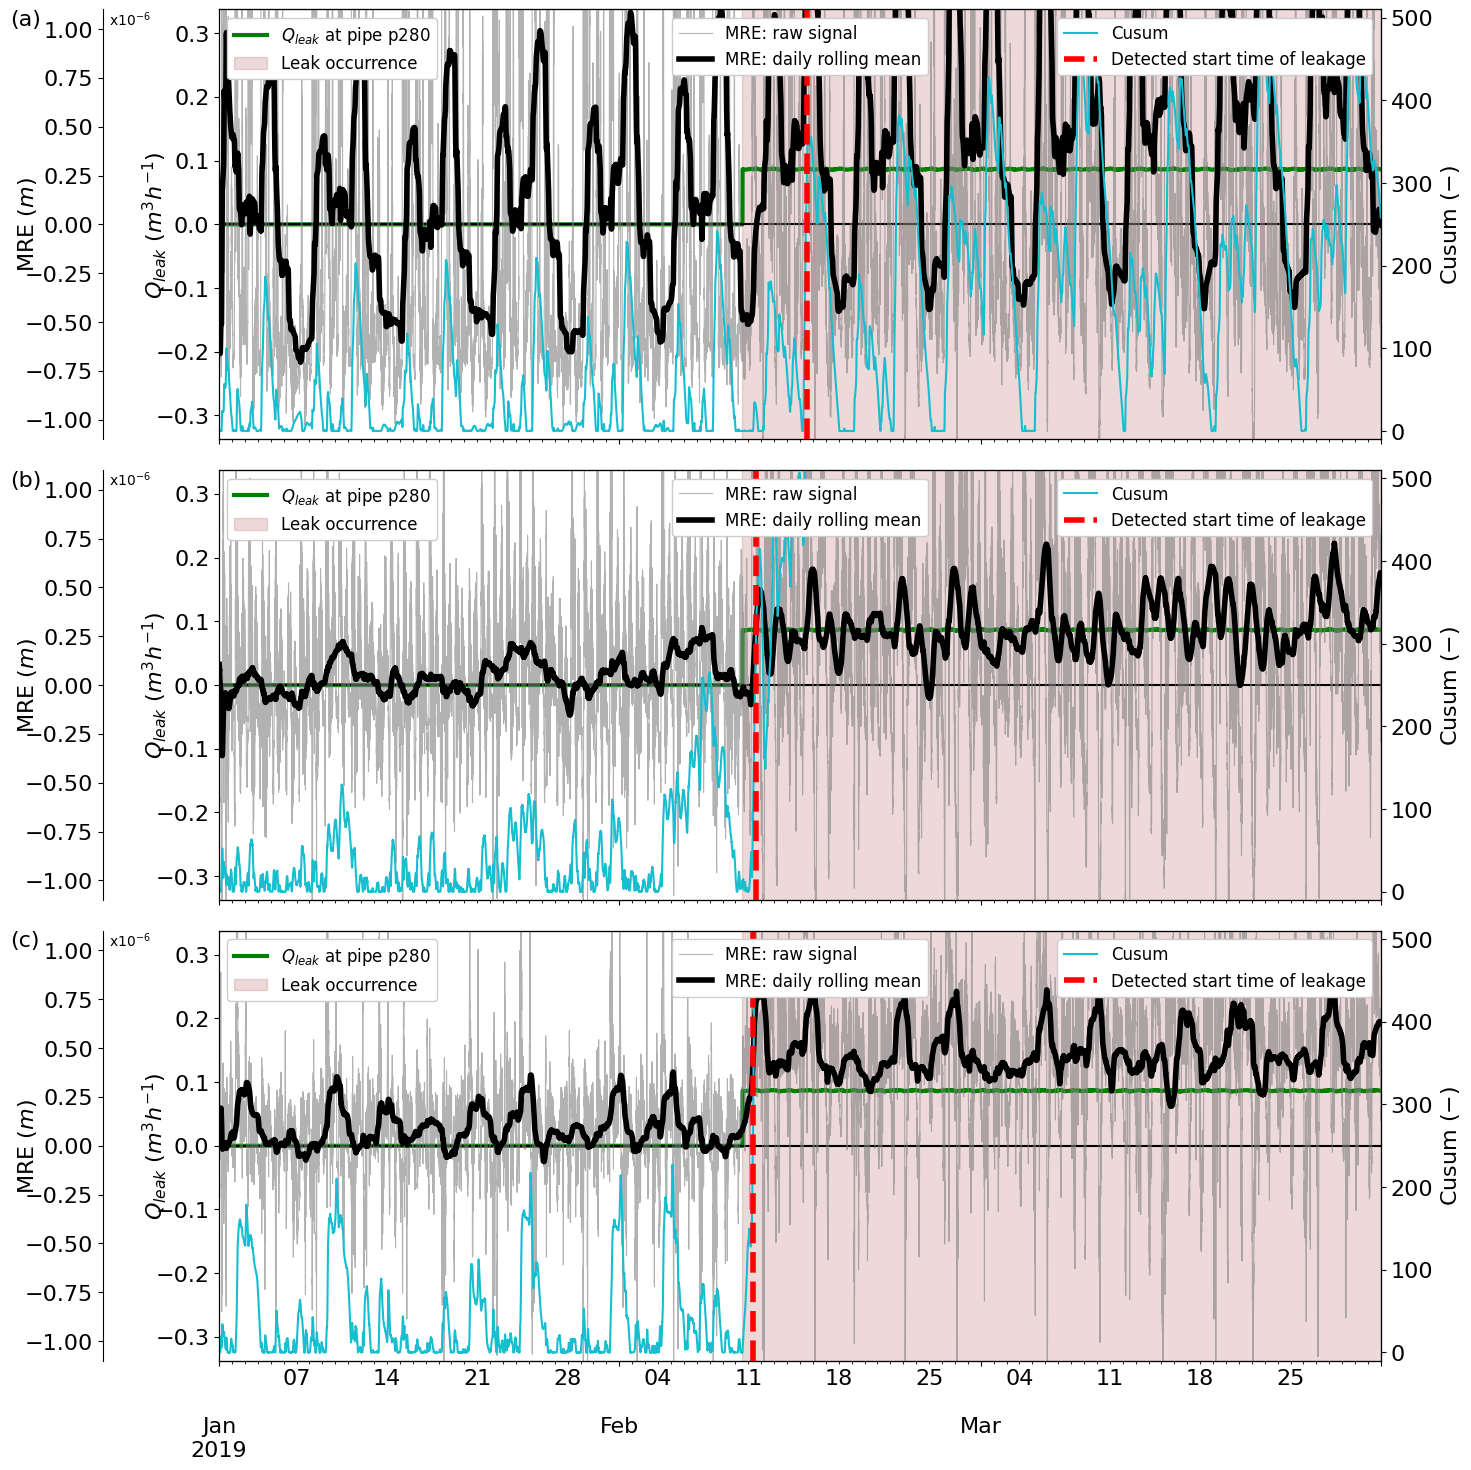

In [12]:
j=16
MRE_QNET = list_MRE_QNET[j]
c_QNET = list_c_QNET[j]
det_QNET = list_det_QNET[j]
d = [1,-1,1]

f,axs = plt.subplots(3,figsize=(15,15),sharex=True,sharey=True)
for i,(e,c,det,label,ax) in enumerate(zip([MRE_BL,MRE_FK,MRE_QNET],[c_BL,c_FK,c_QNET],[det_BL,det_FK,det_QNET],labels,axs)):
    ax.set_ylabel('$Q_{leak}$ ($m^3 h^{-1}$)')
    leak_signals['p280'].loc[test_start:test_end].plot(ax=ax,color='green',label='$Q_{leak}$ at pipe p280',lw=3)
    z = 2.75
    #ax.axvline(pd.to_datetime('2019-05-30 21:55:00'),c='r',lw=2,ls='--',label='Actual start time of leakage')
    ax.fill_between([pd.to_datetime(leak_start),pd.to_datetime('2019-12-30 21:55:00')],[1,1], [-1,-1], color='darkred', alpha=0.15,label='Leak occurrence')
    ax.axhline(0,c='black')
    ax.set_ylim(-leak_signals['p277'].max()*z,leak_signals['p277'].max()*z)
    ax.yaxis.labelpad = -10

    ax2 = ax.twinx()
    ax2.yaxis.tick_left()
    rspine = ax2.spines['left']
    rspine.set_position(('axes', -0.1))
    ax2.yaxis.set_label_position("left")
    (d[i]*e[0]).plot(ax=ax2,label='MRE: raw signal',lw=0.8,alpha=0.6,c='grey')
    (d[i]*e[0]).rolling('D').mean().plot(ax=ax2,label='MRE: daily rolling mean',lw=4,c='black')
    z=[1.1e-6,1.1e-6,1.1e-6]
    ax2.set_ylim(-z[i],z[i])
    ax2.set_ylabel('MRE ($m$)')
    align.yaxes(ax,0,ax2,0,0.5)
    ax2.yaxis.labelpad = -10
    expo = [6,6,6]
    ax2.text(-0.095, 1, r'x$\mathregular{10^{-%d}}$' %expo[i],
             fontsize=10,
             transform=ax2.transAxes,
             horizontalalignment='left',
             verticalalignment='top')
    ax2.text(-0.18, 1, '({})'.format(string.ascii_lowercase[i]),
             fontsize=16,
             transform=ax2.transAxes,
             horizontalalignment='left',
             verticalalignment='top')

    ax3 = ax.twinx()
    ax3.set_ylabel('Cusum ($-$)')
    c[0].plot(ax=ax3,label='Cusum',c='C9')
    if not det.empty:
        ax3.axvline(det.iloc[0],c='r',lw=4,ls='--',label='Detected start time of leakage')
    ax3.set_ylim(-10,510)
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles3, labels3 = ax3.get_legend_handles_labels()
    first_legend = plt.legend(handles1, labels1, loc=2, prop={'size': 12},framealpha=1)
    ax3.add_artist(first_legend)
    second_legend = plt.legend(handles2, labels2, loc=9, prop={'size': 12},framealpha=1)
    ax3.add_artist(second_legend)
    ax3.legend(handles3, labels3, loc=1, prop={'size': 12},framealpha=1)

for i in range(len(f.axes)):
    f.axes[i].yaxis.offsetText.set_visible(False)
f.tight_layout()

## Leak 2

In [13]:
# leak specific parameters
name = 'l2'
leak_start = '2019-05-30 21:55:00'

train_start = '2019-04-01'
train_end   = '2019-04-14'
test_start  = '2019-04-01'
test_end    = '2019-10-31'

In [14]:
# preprocess data to torch
scaler_P = MaxAbsScaler()
P_train,P_val,P_test = preprocess2torch(
    scada_pressure,
    sensor_list,
    train_start = train_start,
    train_end   = train_end,
    test_start  = test_start,
    test_end    = test_end,
    scaler      = scaler_P,
    )
scaler_Q = MaxAbsScaler()
Q_train,Q_val,Q_test = preprocess2torch(
    scada_flows,
    train_start = train_start,
    train_end   = train_end,
    test_start  = test_start,
    test_end    = test_end,
    scaler      = scaler_Q,
    )
tank_ = scada_pressure['T1'].to_frame()
tank_ = (tank_-tank_.mean())/tank_.std()
T_train,T_val,T_test = preprocess2torch(
    tank_,
    train_start = train_start,
    train_end   = train_end,
    test_start  = test_start,
    test_end    = test_end,
    )

In [15]:
# loading pre-trained LILA-PINN models
with open(u_path+'list_model_{}_s{}.pkl'.format(name,3), 'rb') as f:
    list_model_QNET = pickle.load(f)

# training regression models for comparison
model_BL = calibrate_LILA(P_train, sensor_list=sensor_list, hyperparams=False, Q_train=T_train)
model_FK = calibrate_LILA(P_train, sensor_list=sensor_list, hyperparams=False, Q_train=torch.cat((Q_train,T_train),axis=1))

In [16]:
# performing CPD

# loading results from pre-trained models
with open(u_path+'list_MRE_{}_s{}.pkl'.format(name,3), 'rb') as f:
    list_MRE_QNET = pickle.load(f)
with open(u_path+'list_c_{}_s{}.pkl'.format(name,3), 'rb') as f:
    list_c_QNET = pickle.load(f)
with open(u_path+'list_det_{}_s{}.pkl'.format(name,3), 'rb') as f:
    list_det_QNET = pickle.load(f)
    
# evaluating regression models for comparison
MRE_BL = pd.DataFrame(
    model_BL.predict_MRE(P_test,T_test).mean(axis=(1,2)).detach().numpy(),
    index=pd.date_range(start=test_start,freq='5T',periods=P_test.shape[0]),
    )
det_BL,c_BL = cusum(MRE_BL,delta=delta,C_thr=C_thr,est_length=est_length)
MRE_FK = pd.DataFrame(
    model_FK.predict_MRE(P_test,torch.cat((Q_test,T_test),axis=1)).mean(axis=(1,2)).detach().numpy(),
    index=pd.date_range(start=test_start,freq='5T',periods=P_test.shape[0]),
    )
det_FK,c_FK = cusum(MRE_FK,delta=delta,C_thr=C_thr,est_length=est_length)

### Figure 5

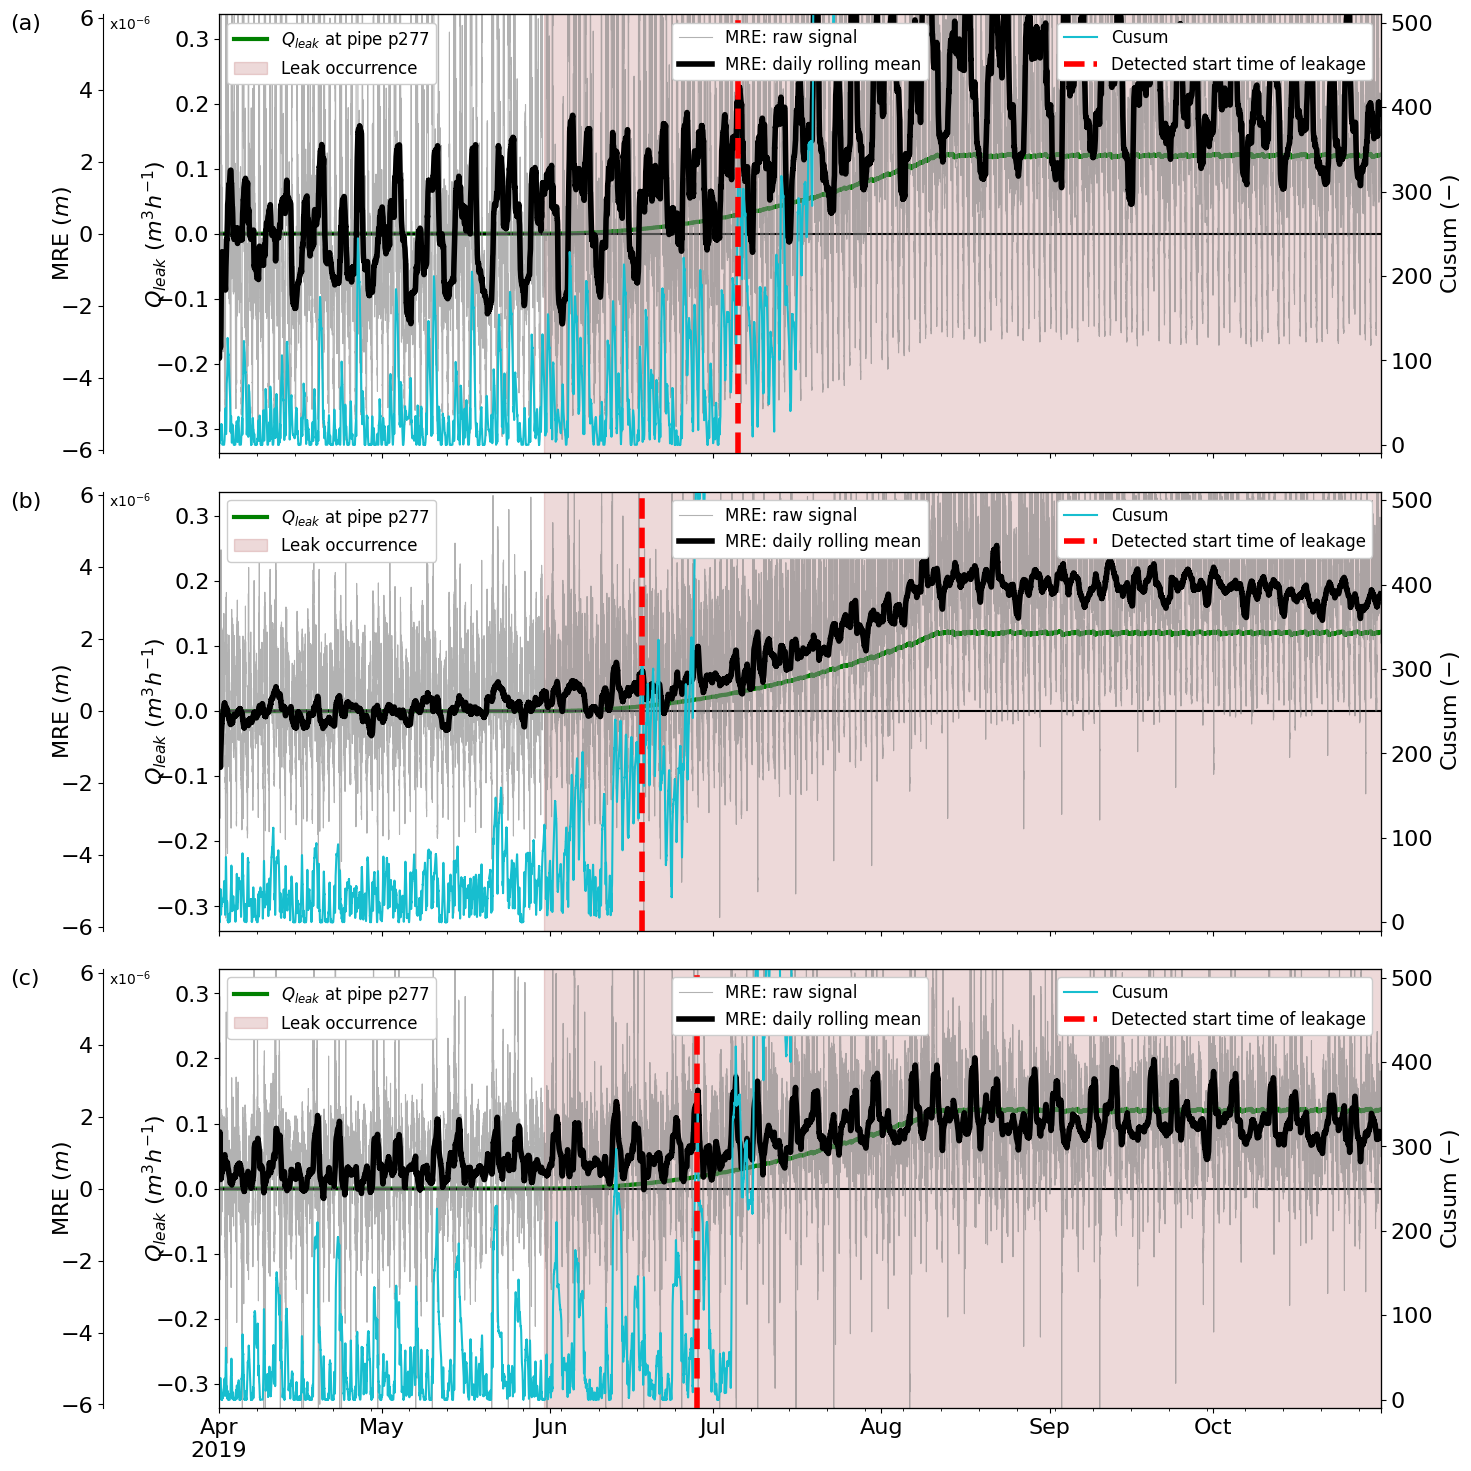

In [19]:
j=93
MRE_QNET = list_MRE_QNET[j]
c_QNET = list_c_QNET[j]
det_QNET = list_det_QNET[j]
d = [1,1,1]

f,axs = plt.subplots(3,figsize=(15,15),sharex=True,sharey=True)
for i,(e,c,det,label,ax) in enumerate(zip([MRE_BL,MRE_FK,MRE_QNET],[c_BL,c_FK,c_QNET],[det_BL,det_FK,det_QNET],labels,axs)):
    ax.set_ylabel('$Q_{leak}$ ($m^3 h^{-1}$)')
    leak_signals['p277'].loc[test_start:test_end].plot(ax=ax,color='green',label='$Q_{leak}$ at pipe p277',lw=3)
    z = 2.75
    #ax.axvline(pd.to_datetime('2019-05-30 21:55:00'),c='r',lw=2,ls='--',label='Actual start time of leakage')
    ax.fill_between([pd.to_datetime(leak_start),pd.to_datetime('2019-12-30 21:55:00')],[1,1], [-1,-1], color='darkred', alpha=0.15,label='Leak occurrence')
    ax.axhline(0,c='black')
    ax.set_ylim(-leak_signals['p277'].max()*z,leak_signals['p277'].max()*z)
    ax.yaxis.labelpad = -10

    ax2 = ax.twinx()
    ax2.yaxis.tick_left()
    rspine = ax2.spines['left']
    rspine.set_position(('axes', -0.1))
    ax2.yaxis.set_label_position("left")
    (d[i]*e[0]).plot(ax=ax2,label='MRE: raw signal',lw=0.8,alpha=0.6,c='grey')
    (d[i]*e[0]).rolling('D').mean().plot(ax=ax2,label='MRE: daily rolling mean',lw=4,c='black')
    z=[6.1e-6,6.1e-6,6.1e-6]
    ax2.set_ylim(-z[i],z[i])
    ax2.set_ylabel('MRE ($m$)')
    align.yaxes(ax,0,ax2,0,0.5)
    ax2.yaxis.labelpad = -10
    ax2.text(-0.095, 1, r'x$\mathregular{10^{-6}}$',
             fontsize=10,
             transform=ax2.transAxes,
             horizontalalignment='left',
             verticalalignment='top')
    ax2.text(-0.18, 1, '({})'.format(string.ascii_lowercase[i]),
             fontsize=16,
             transform=ax2.transAxes,
             horizontalalignment='left',
             verticalalignment='top')

    ax3 = ax.twinx()
    ax3.set_ylabel('Cusum ($-$)')
    c[0].plot(ax=ax3,label='Cusum',c='C9')
    if not det.empty:
        ax3.axvline(det.iloc[0],c='r',lw=4,ls='--',label='Detected start time of leakage')
    ax3.set_ylim(-10,510)
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles3, labels3 = ax3.get_legend_handles_labels()
    first_legend = plt.legend(handles1, labels1, loc=2, prop={'size': 12},framealpha=1)
    ax3.add_artist(first_legend)
    second_legend = plt.legend(handles2, labels2, loc=9, prop={'size': 12},framealpha=1)
    ax3.add_artist(second_legend)
    ax3.legend(handles3, labels3, loc=1, prop={'size': 12},framealpha=1)

for i in range(len(f.axes)):
    f.axes[i].yaxis.offsetText.set_visible(False)
f.tight_layout()